### Question 1: How do an album's genre and release year influence its ranking changes from 2003 to 2020?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

df = pd.read_csv('../data/rolling_stone.csv')

In [2]:
# Preprocess data
df['rank_2003'] = df['rank_2003'].fillna(df['rank_2003'].mean())
df['rank_2020'] = df['rank_2020'].fillna(df['rank_2020'].mean())
df['genre'] = df['genre'].fillna('Unknown')
df['artist_gender'] = df['artist_gender'].fillna('Unknown')
df['artist_member_count'] = df['artist_member_count'].fillna(1)
df['spotify_popularity'] = df['spotify_popularity'].fillna(df['spotify_popularity'].mean()) #
df = df.dropna()

df['decade'] = (df['release_year'] // 10 * 10).astype(str) + 's'
df['group_size'] = pd.cut(
    df['artist_member_count'], 
    bins=[0, 1, 4, float('inf')], 
    labels=['Solo', 'Small Group', 'Large Group'], 
    right=True
)

In [3]:
from scipy.stats import f_oneway

genre_groups = [df['differential'][df['genre'] == g] for g in df['genre'].unique()]
anova_result = f_oneway(*genre_groups)
print(f"ANOVA p-value for genre vs differential: {anova_result.pvalue:.4f}")
# If p < 0.05, genre likely influences differential significantly

ANOVA p-value for genre vs differential: 0.0000


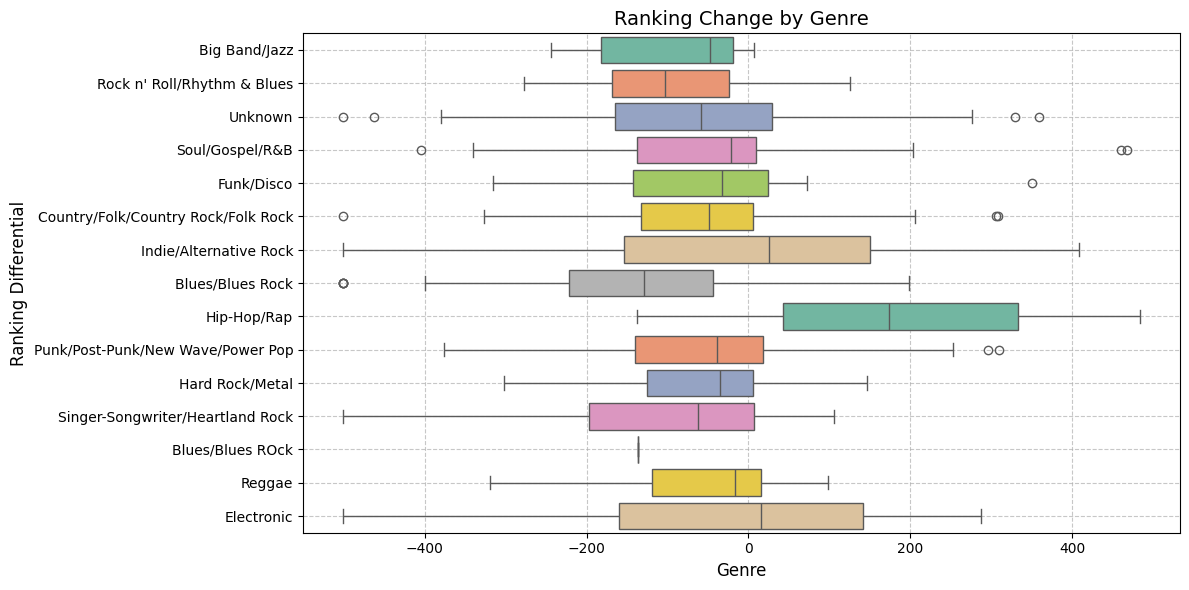

In [4]:
plt.figure(figsize=(12, 6))
sns.boxplot(y='genre', x='differential', data=df, hue='genre', palette='Set2', legend=False)
plt.title('Ranking Change by Genre', fontsize=14)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Ranking Differential', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

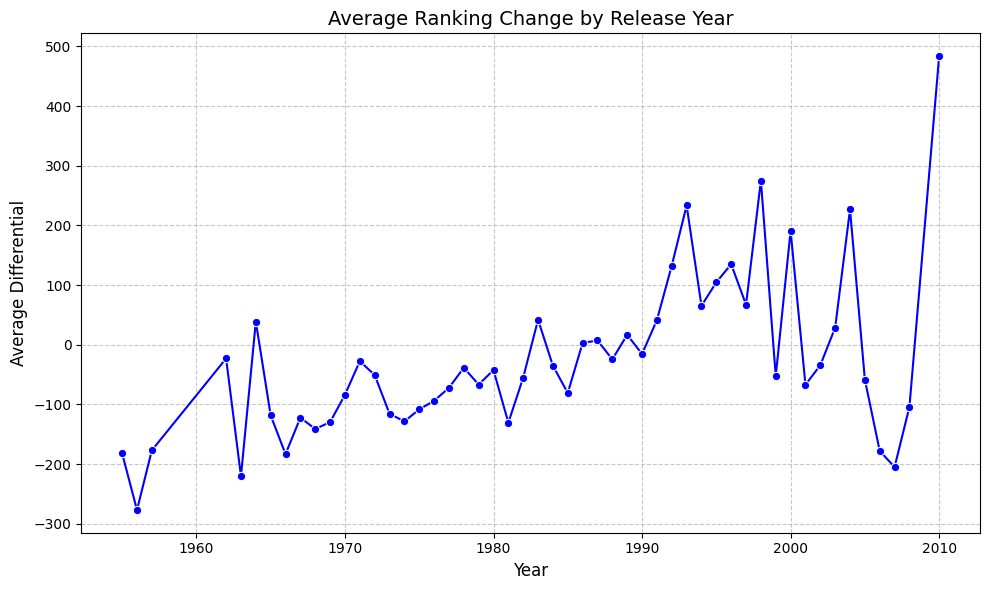

In [5]:
decade_avg = df.groupby('release_year')['differential'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(x='release_year', y='differential', data=decade_avg, marker='o', color='b')
plt.title('Average Ranking Change by Release Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Differential', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

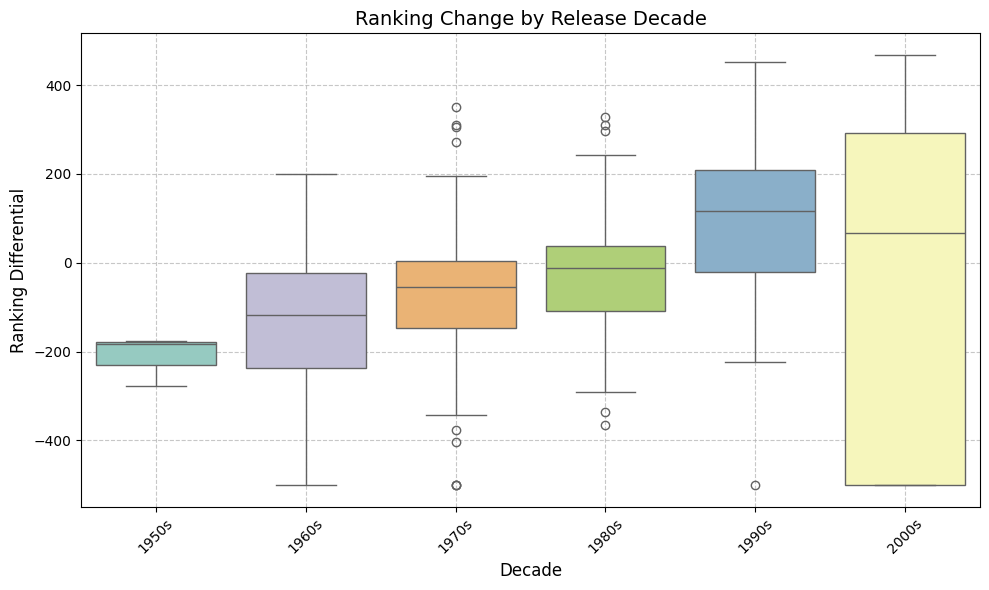

In [6]:
decade_order = ['1950s', '1960s', '1970s', '1980s', '1990s', '2000s']

plt.figure(figsize=(10, 6))
sns.boxplot(x='decade', y='differential', data=df, order=decade_order, hue='decade', palette='Set3', legend=False)
plt.title('Ranking Change by Release Decade', fontsize=14)
plt.xlabel('Decade', fontsize=12)
plt.ylabel('Ranking Differential', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Question 2: How do an artist gender and group size affect album popularity on Spotify?

                            OLS Regression Results                            
Dep. Variable:     spotify_popularity   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                   0.02230
Date:                Thu, 10 Apr 2025   Prob (F-statistic):               1.00
Time:                        22:35:59   Log-Likelihood:                -1619.8
No. Observations:                 400   AIC:                             3252.
Df Residuals:                     394   BIC:                             3276.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

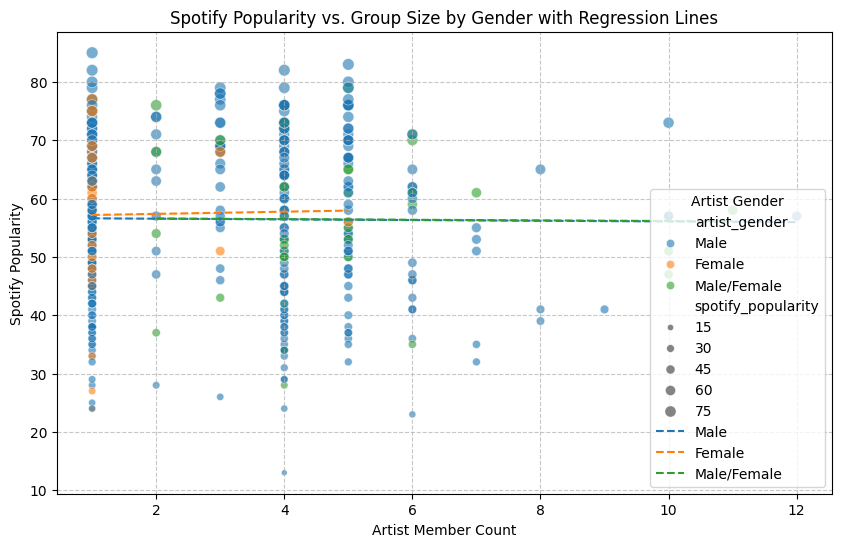

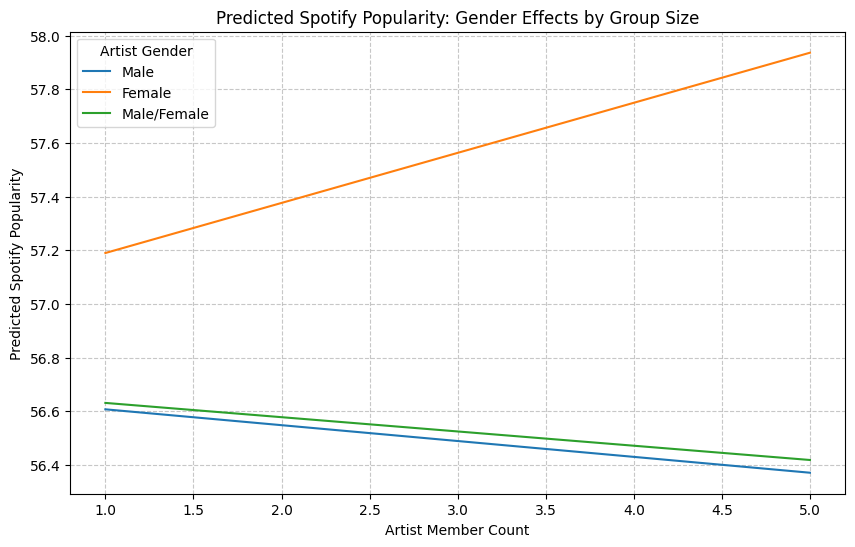

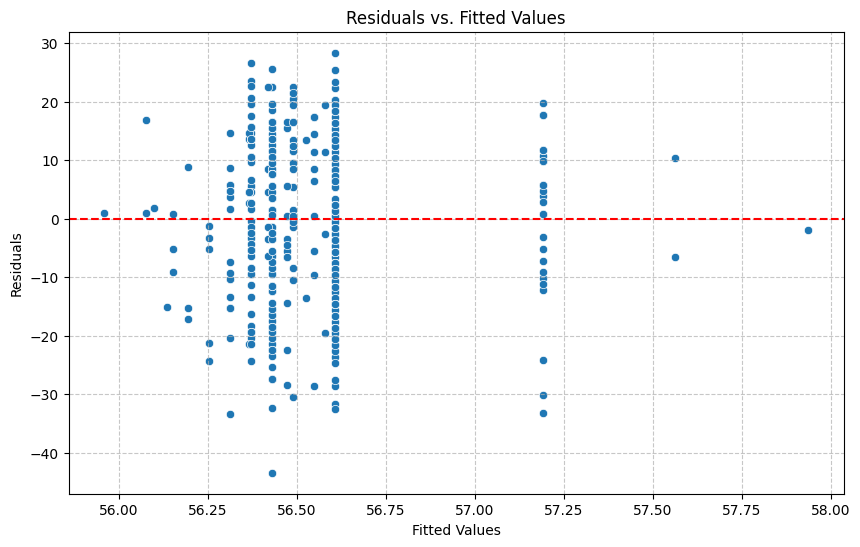

In [7]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Step 1: Regression Analysis
# Fit OLS model with interaction term
model = smf.ols('spotify_popularity ~ C(artist_gender) + artist_member_count + C(artist_gender):artist_member_count', data=df).fit()

# Print summary
print(model.summary())

# Step 2: Extract Predictions
df['predicted_popularity'] = model.predict(df)

# Step 3: Visualizations
# 1. Scatter Plot with Regression Lines (Interaction Effect)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='artist_member_count', y='spotify_popularity', hue='artist_gender', size='spotify_popularity', data=df, alpha=0.6)
sns.lineplot(x='artist_member_count', y='predicted_popularity', hue='artist_gender', data=df, linestyle='--')
plt.title('Spotify Popularity vs. Group Size by Gender with Regression Lines')
plt.xlabel('Artist Member Count')
plt.ylabel('Spotify Popularity')
plt.legend(title='Artist Gender')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 2. Interaction Plot (Effect of Gender Across Member Count)
# Create a range of member counts for prediction
gender_levels = df['artist_gender'].unique()
member_counts = range(1, 6)  # Example range; adjust based on your data
pred_data = pd.DataFrame({
    'artist_gender': [g for g in gender_levels for _ in member_counts],
    'artist_member_count': list(member_counts) * len(gender_levels)
})
pred_data['predicted_popularity'] = model.predict(pred_data)

plt.figure(figsize=(10, 6))
sns.lineplot(x='artist_member_count', y='predicted_popularity', hue='artist_gender', data=pred_data)
plt.title('Predicted Spotify Popularity: Gender Effects by Group Size')
plt.xlabel('Artist Member Count')
plt.ylabel('Predicted Spotify Popularity')
plt.legend(title='Artist Gender')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 3. Residual Plot (Model Fit Check)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=model.fittedvalues, y=model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [8]:
fig = px.scatter(
    df,
    x='artist_member_count',
    y='spotify_popularity',
    color='artist_gender',  
    size='spotify_popularity',  
    title='Spotify Popularity vs. Group Size by Gender',
    labels={
        'artist_member_count': 'Artist Member Count',
        'spotify_popularity': 'Spotify Popularity',
        'artist_gender': 'Artist Gender'
    },
)
fig.show()

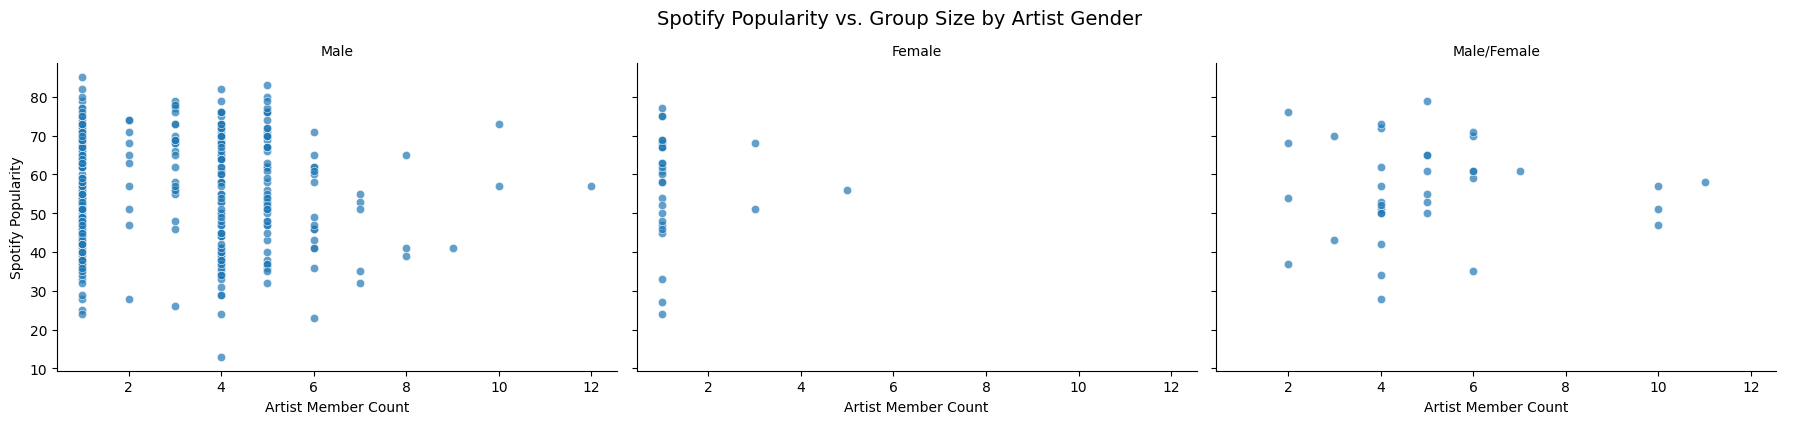

In [9]:
g = sns.FacetGrid(df, col='artist_gender', height=4, aspect=1.5)
g.map(sns.scatterplot, 'artist_member_count', 'spotify_popularity', alpha=0.7)
g.add_legend()
g.set_titles('{col_name}')
g.set_axis_labels('Artist Member Count', 'Spotify Popularity')
plt.suptitle('Spotify Popularity vs. Group Size by Artist Gender', y=1.05, fontsize=14)
plt.show()

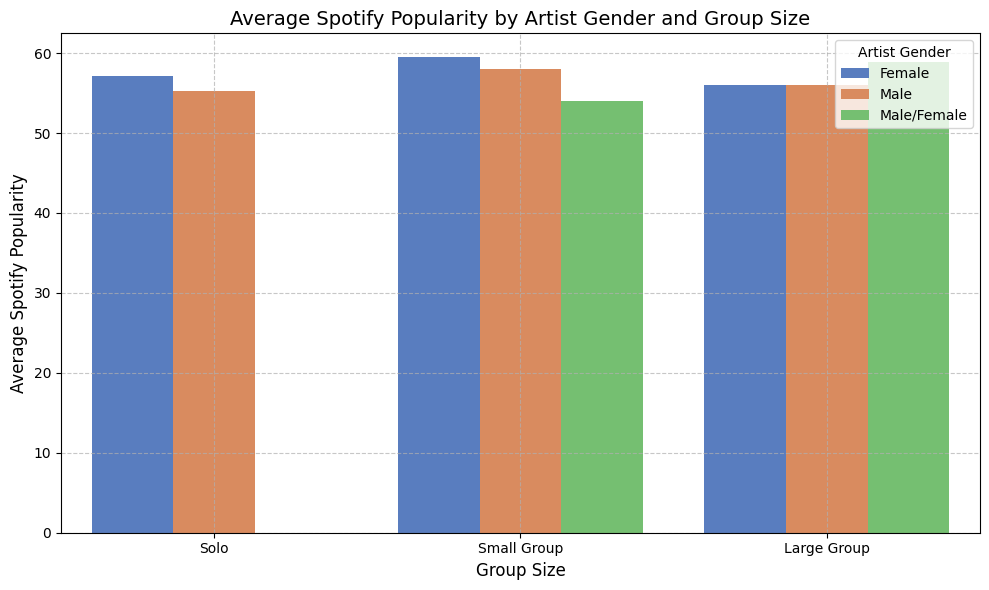

In [10]:
df['group_size'] = pd.cut(
    df['artist_member_count'], 
    bins=[0, 1, 4, float('inf')], 
    labels=['Solo', 'Small Group', 'Large Group'], 
    right=True
)
popularity_by_group = df.groupby(['artist_gender', 'group_size'], observed=True)['spotify_popularity'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(
    x='group_size', 
    y='spotify_popularity', 
    hue='artist_gender', 
    data=popularity_by_group, 
    palette='muted'
)
plt.title('Average Spotify Popularity by Artist Gender and Group Size', fontsize=14)
plt.xlabel('Group Size', fontsize=12)
plt.ylabel('Average Spotify Popularity', fontsize=12)
plt.legend(title='Artist Gender')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Interactive dashboard 

In [13]:
from dash import Dash, dcc, html, Input, Output

# Initialize Dash app
app = Dash(__name__)

# Layout of the dashboard
app.layout = html.Div([
    html.H1("Interactive Dashboard: Rolling Stone 500 Greatest Albums", style={'textAlign': 'center'}),

    # Question 1 Section
    html.H2("Q1: How do Genre and Release Year Influence Ranking Changes?"),
    html.Label("Select Genre(s):"),
    dcc.Dropdown(
        id='genre-dropdown',
        options=[{'label': g, 'value': g} for g in df['genre'].unique()],
        value=df['genre'].unique().tolist(),  # Default: all genres
        multi=True
    ),
    dcc.Graph(id='box-plot-genre'),
    dcc.Graph(id='line-plot-decade'),

    # Question 2 Section
    html.H2("Q2: How do Artist Gender and Group Size Affect Spotify Popularity?"),
    html.Label("Select Gender(s):"),
    dcc.Dropdown(
        id='gender-dropdown',
        options=[{'label': g, 'value': g} for g in df['artist_gender'].unique()],
        value=df['artist_gender'].unique().tolist(),  # Default: all genders
        multi=True
    ),
    dcc.Graph(id='scatter-plot-gender'),
    dcc.Graph(id='bar-plot-popularity')
])

# Callback for Question 1: Update plots based on genre selection
@app.callback(
    [Output('box-plot-genre', 'figure'), 
     Output('line-plot-decade', 'figure')],  
    [Input('genre-dropdown', 'value')]
)
def update_q1_plots(selected_genres):
    # Filter data by selected genres
    filtered_df = df[df['genre'].isin(selected_genres)]

    # Box plot: Differential by Genre
    box_fig = px.box(
        filtered_df, 
        x='genre', 
        y='differential', 
        title='Ranking Change by Genre',
        labels={'differential': 'Ranking Differential', 'genre': 'Genre'}
    )

    # Line plot: Average Differential by Decade
    decade_avg = filtered_df.groupby('decade')['differential'].mean().reset_index()
    line_fig = px.line(
        decade_avg, 
        x='decade', 
        y='differential', 
        title='Average Ranking Change by Decade',
        labels={'differential': 'Average Differential', 'decade': 'Decade'},
        markers=True
    )

    return box_fig, line_fig


# Callback for Question 2: Update plots based on gender selection
@app.callback(
    [Output('scatter-plot-gender', 'figure'), Output('bar-plot-popularity', 'figure')],
    [Input('gender-dropdown', 'value')]
)
def update_q2_plots(selected_genders):
    # Filter data by selected genders
    filtered_df = df[df['artist_gender'].isin(selected_genders)]

    # Scatter plot: Member Count vs. Popularity, colored by Gender
    scatter_fig = px.scatter(
        filtered_df, 
        x='artist_member_count', 
        y='spotify_popularity', 
        color='artist_gender', 
        title='Spotify Popularity vs. Group Size by Gender',
        labels={'artist_member_count': 'Artist Member Count', 'spotify_popularity': 'Spotify Popularity'},
        facet_col='artist_gender'
    )

    # Bar plot: Average Popularity by Gender and Group Size
    popularity_by_group = filtered_df.groupby(['artist_gender', 'group_size'], observed=True)['spotify_popularity'].mean().reset_index()
    bar_fig = px.bar(
        popularity_by_group, 
        x='group_size', 
        y='spotify_popularity', 
        color='artist_gender', 
        barmode='group',
        title='Average Spotify Popularity by Gender and Group Size',
        labels={'spotify_popularity': 'Average Spotify Popularity', 'group_size': 'Group Size'}
    )

    return scatter_fig, bar_fig

# Run the app
if __name__ == '__main__':
    app.run(debug=True, port=4747)

### Experiment

In [14]:
fig = px.scatter(df, x='release_year', y='differential', color='genre', 
                 title='Ranking Differential vs. Release Year by Genre',
                 labels={'differential': 'Differential'})
fig.show()

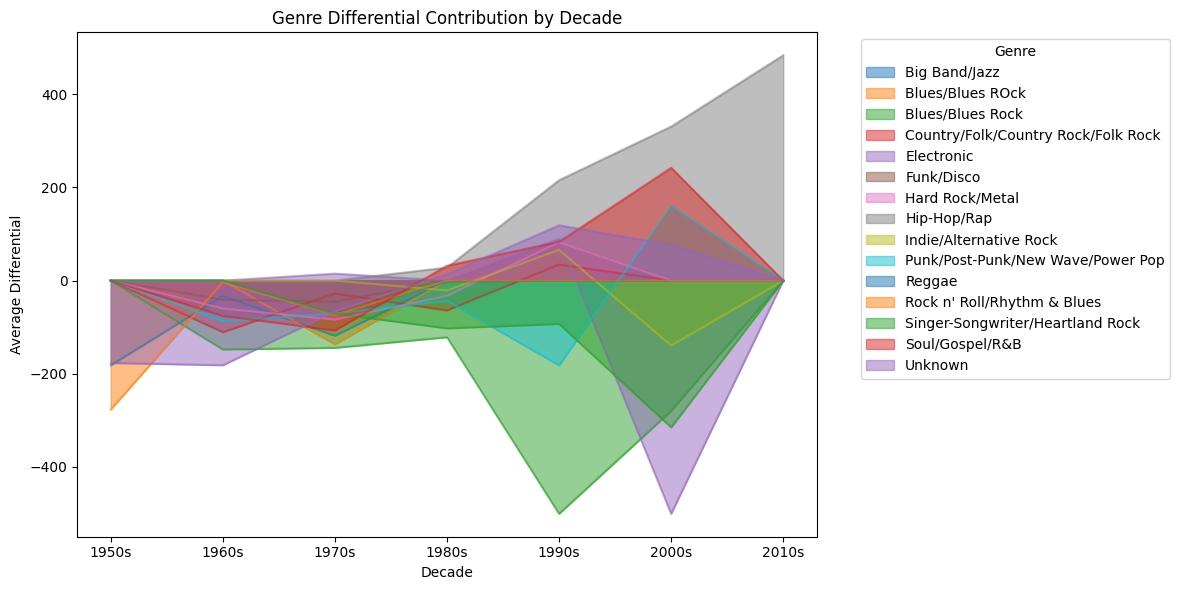

In [15]:
genre_decade = df.groupby(['decade', 'genre'])['differential'].mean().unstack().fillna(0)
genre_decade.plot(kind='area', stacked=False, figsize=(12, 6))
plt.title('Genre Differential Contribution by Decade')
plt.xlabel('Decade')
plt.ylabel('Average Differential')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

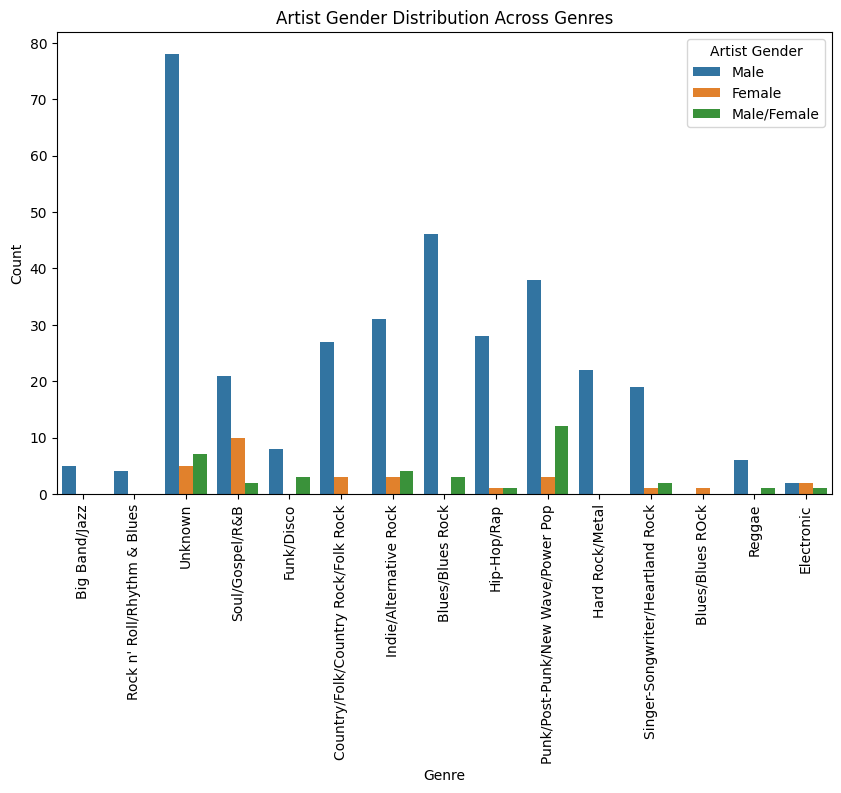

In [16]:
# Artist Gender Analysis
plt.figure(figsize=(10, 6))
sns.countplot(x='genre', data=df, hue='artist_gender')
plt.title('Artist Gender Distribution Across Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Artist Gender')
plt.show()

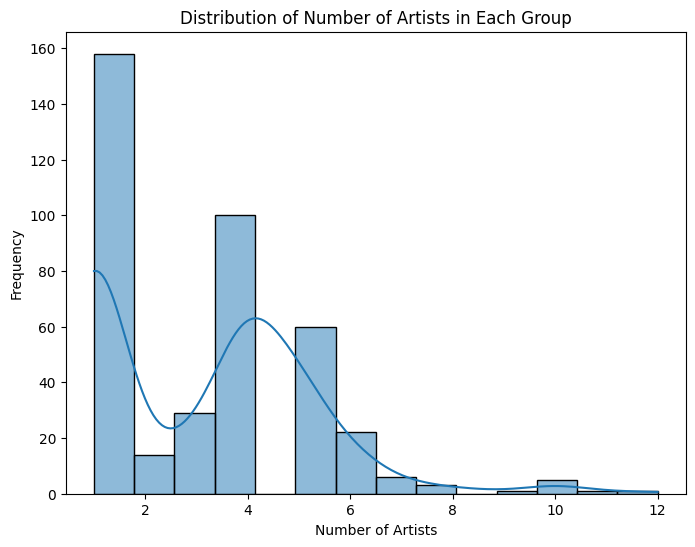

In [17]:
# Distribution of the number of artists in each group
plt.figure(figsize=(8, 6))
sns.histplot(df['artist_member_count'], kde=True)
plt.title('Distribution of Number of Artists in Each Group')
plt.xlabel('Number of Artists')
plt.ylabel('Frequency')
plt.show()

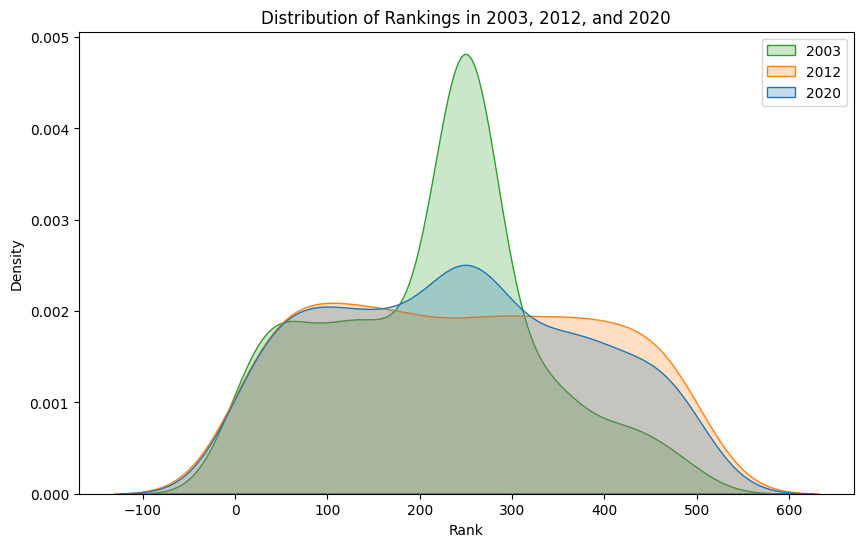

In [18]:
# Distribution of rankings in 2003, 2012, and 2020
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df[['rank_2003', 'rank_2012', 'rank_2020']], fill=True, common_norm=False)
plt.title('Distribution of Rankings in 2003, 2012, and 2020')
plt.xlabel('Rank')
plt.ylabel('Density')
plt.legend(['2003', '2012', '2020'])
plt.show()

## Further Analysis

Correlation with spotify_popularity:
spotify_popularity          1.000000
weeks_on_billboard          0.396918
debut_album_release_year    0.323288
release_year                0.265830
differential                0.230123
predicted_popularity        0.016820
artist_birth_year_sum      -0.008823
artist_member_count        -0.011134
years_between              -0.104761
rank_2012                  -0.115423
ave_age_at_top_500         -0.136078
rank_2003                  -0.141067
rank_2020                  -0.266257
peak_billboard_position    -0.388771
Name: spotify_popularity, dtype: float64


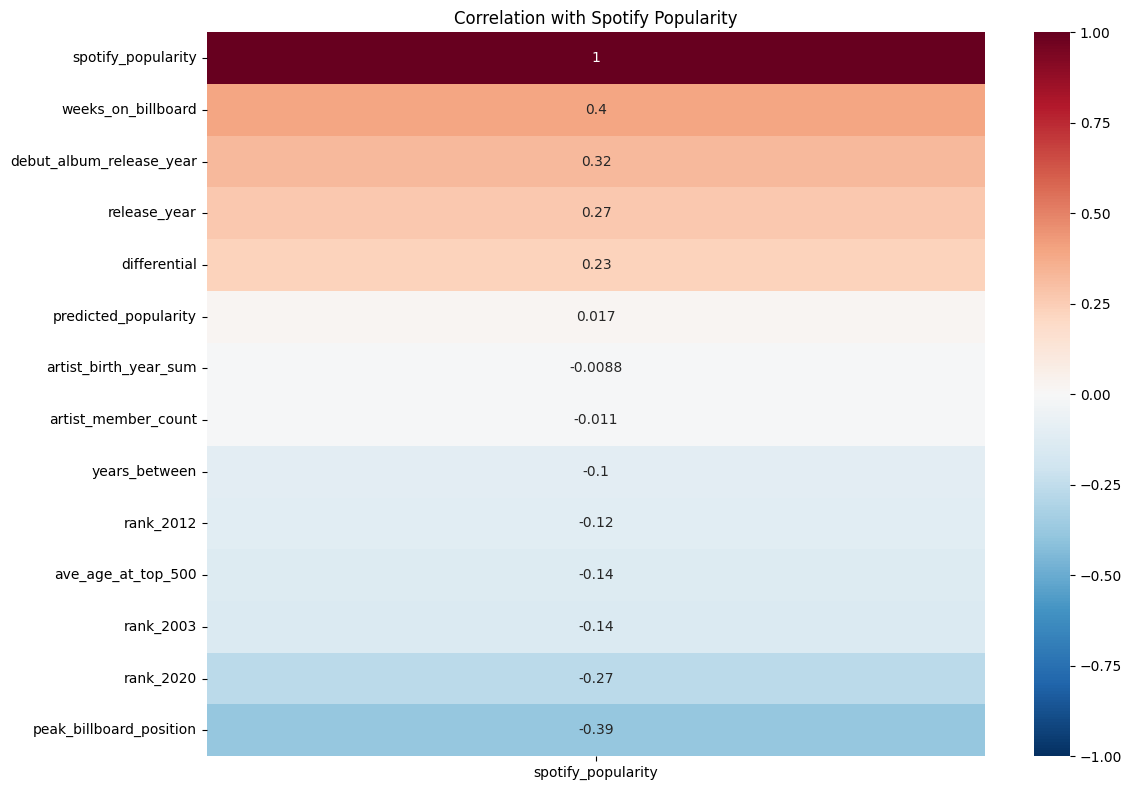

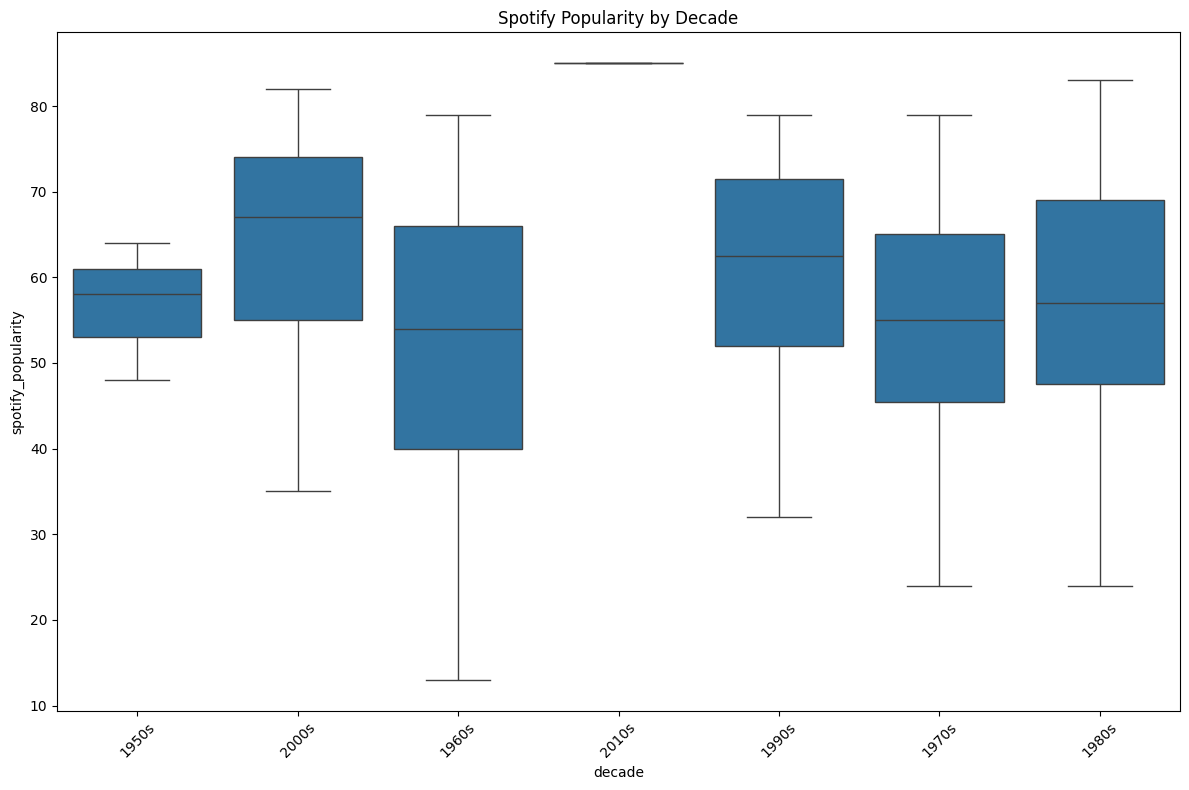

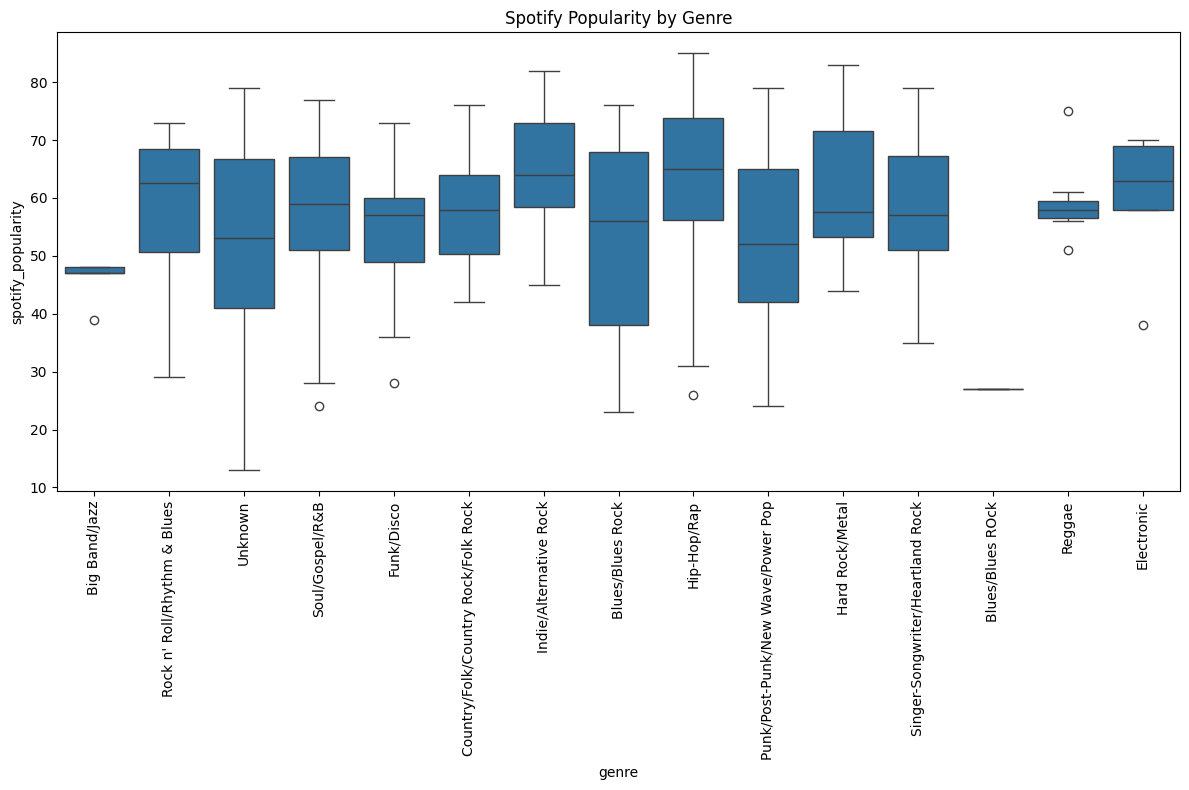

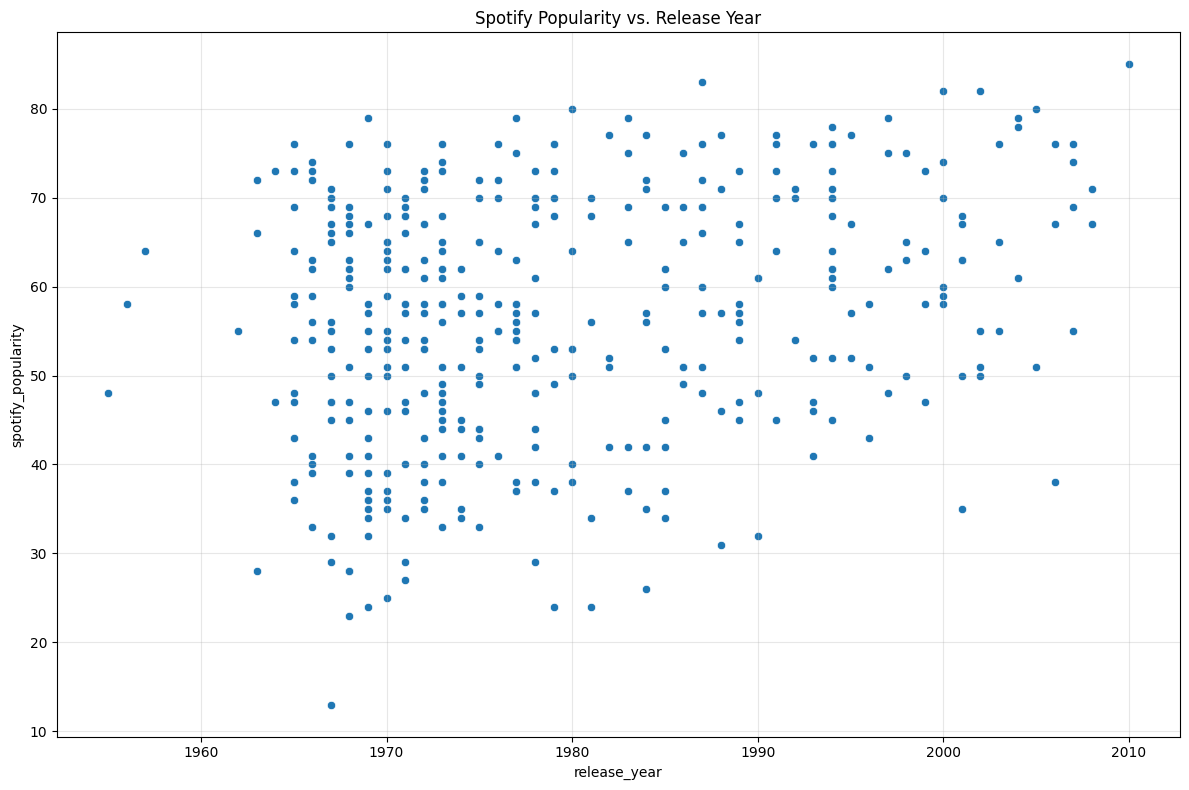

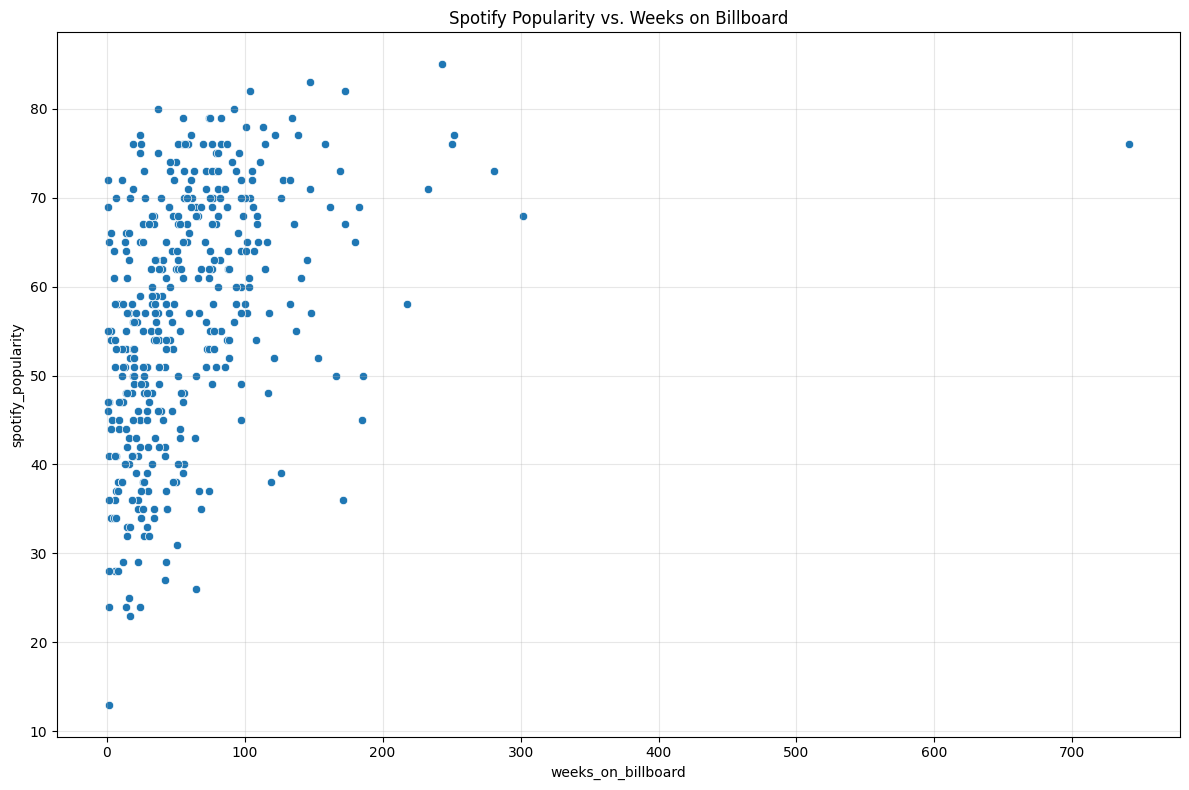

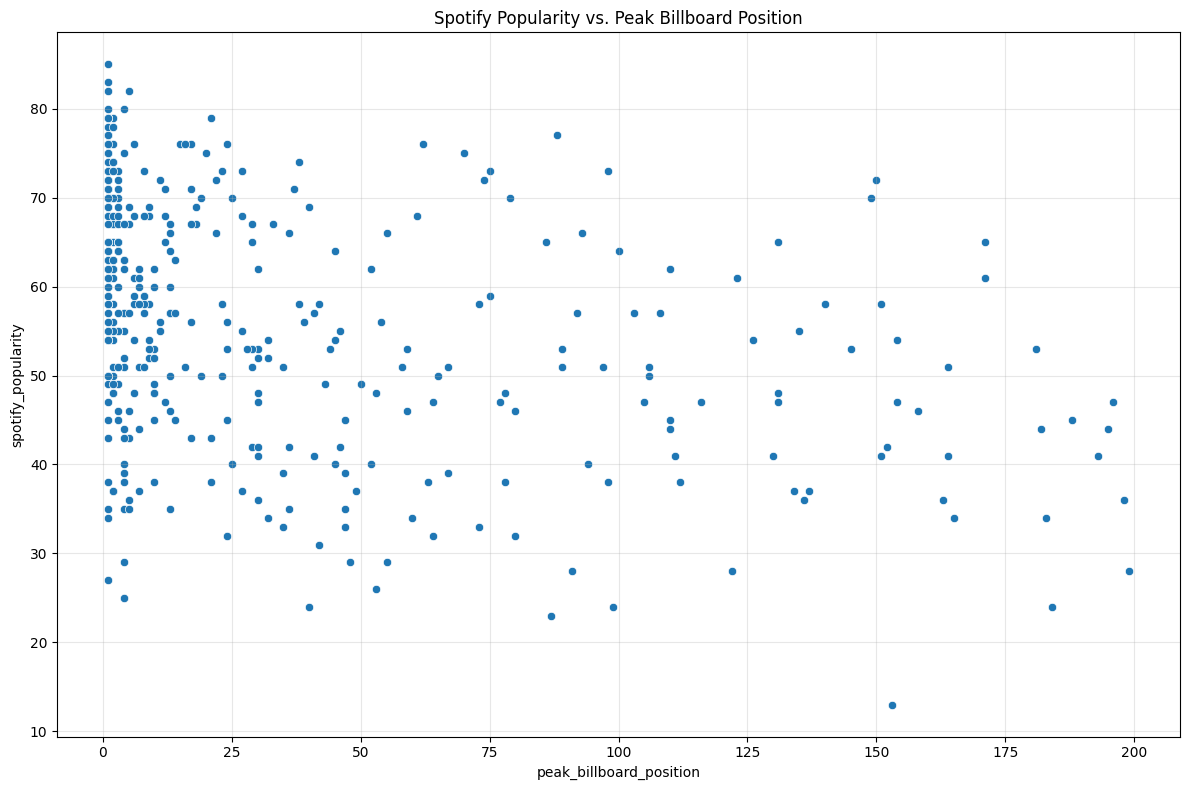

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

numerical_features = df.select_dtypes(include=[np.number])
correlations = numerical_features.corr()['spotify_popularity'].sort_values(ascending=False)
print("Correlation with spotify_popularity:")
print(correlations)

plt.figure(figsize=(12, 8))
sns.heatmap(numerical_features.corr()[['spotify_popularity']].sort_values(by='spotify_popularity', ascending=False), 
            annot=True, cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Correlation with Spotify Popularity')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='decade', y='spotify_popularity', data=df)
plt.title('Spotify Popularity by Decade')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='genre', y='spotify_popularity', data=df)
plt.title('Spotify Popularity by Genre')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Let's examine release_year vs spotify_popularity
plt.figure(figsize=(12, 8))
sns.scatterplot(x='release_year', y='spotify_popularity', data=df)
plt.title('Spotify Popularity vs. Release Year')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check for relationship between billboard performance and spotify popularity
plt.figure(figsize=(12, 8))
sns.scatterplot(x='weeks_on_billboard', y='spotify_popularity', data=df)
plt.title('Spotify Popularity vs. Weeks on Billboard')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.scatterplot(x='peak_billboard_position', y='spotify_popularity', data=df)
plt.title('Spotify Popularity vs. Peak Billboard Position')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

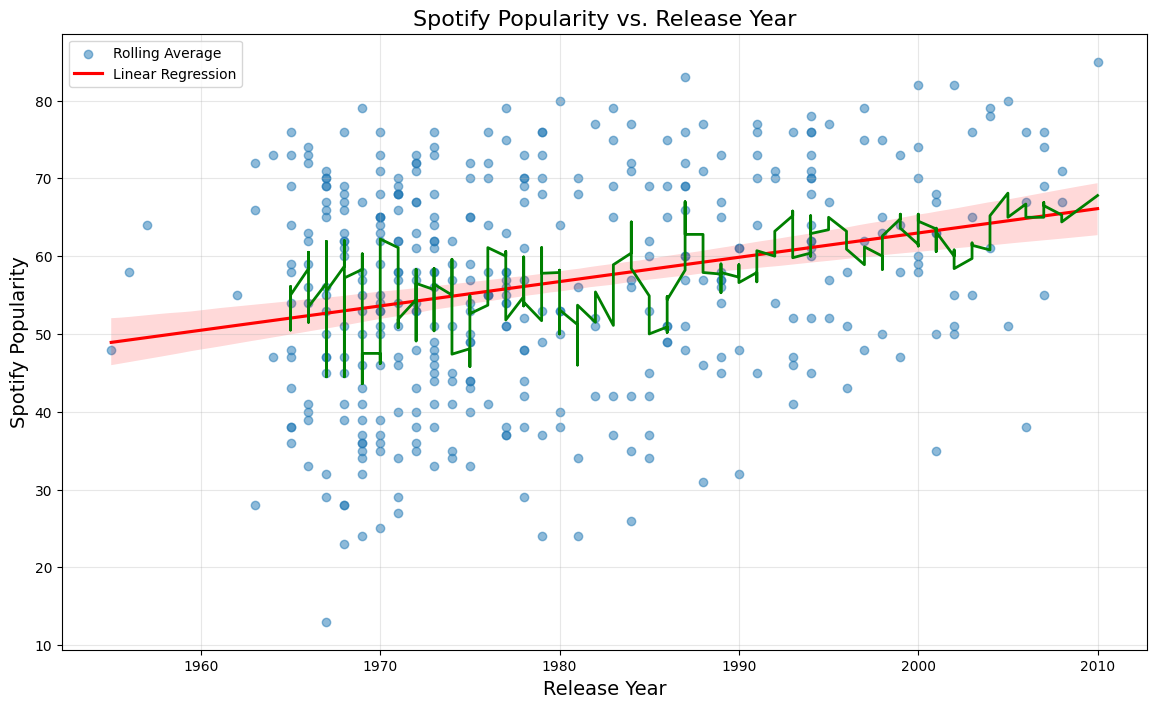

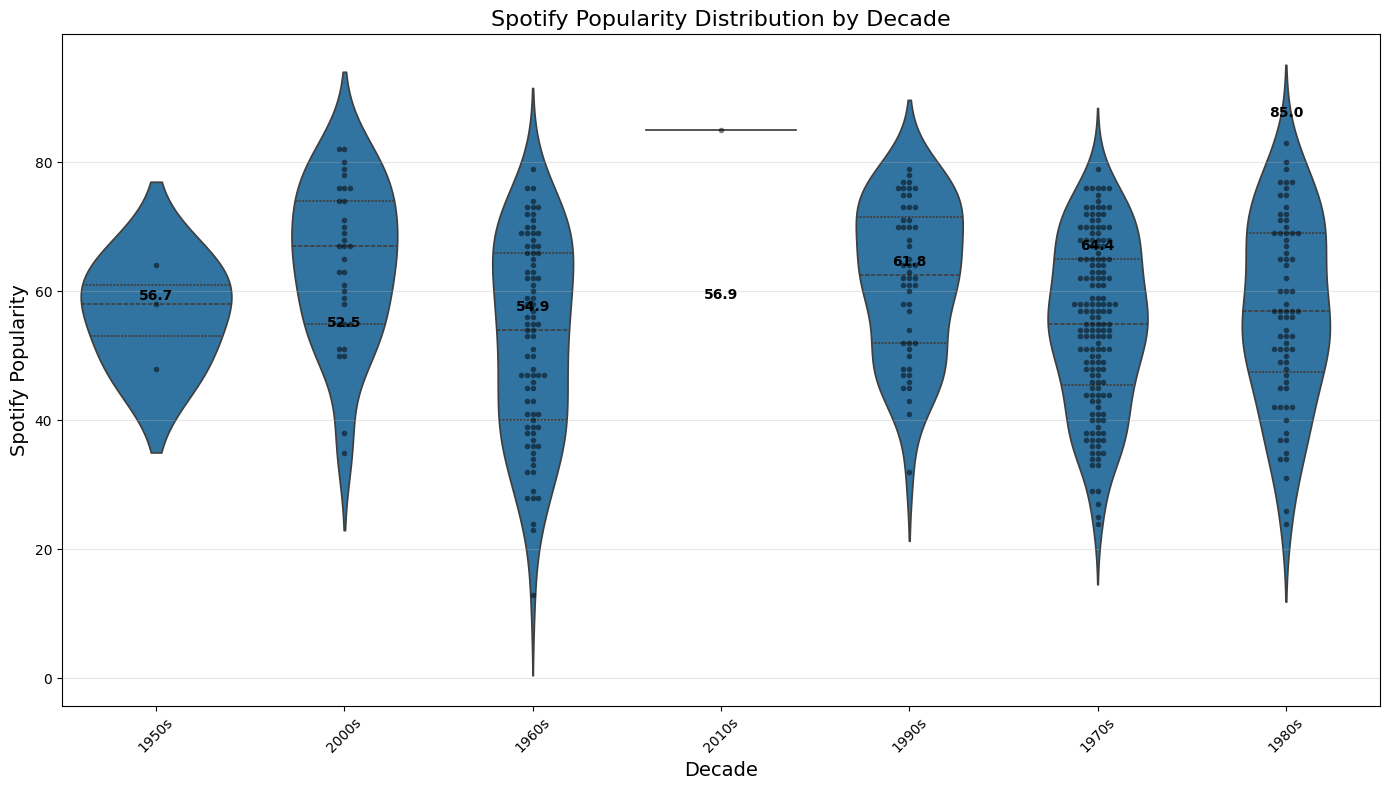

ANOVA test for decade vs. spotify_popularity: F=5.63, p=0.0000
Correlation between release_year and spotify_popularity: r=0.2658, p=0.0000


In [20]:

# 1. Create a visualization for release_year vs. spotify_popularity
plt.figure(figsize=(14, 8))
sns.regplot(x='release_year', y='spotify_popularity', data=df, 
           scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

# Add a rolling average to see the trend more clearly
df_sorted = df.sort_values('release_year')
window_size = 10  # adjust window size as needed
df_sorted['rolling_avg'] = df_sorted['spotify_popularity'].rolling(window=window_size).mean()

plt.plot(df_sorted['release_year'], df_sorted['rolling_avg'], color='green', linewidth=2)
plt.grid(True, alpha=0.3)
plt.title('Spotify Popularity vs. Release Year', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Spotify Popularity', fontsize=14)
plt.legend(['Rolling Average', 'Linear Regression'])
plt.show()

# 2. Create a visualization for decade vs. spotify_popularity (categorical)
plt.figure(figsize=(14, 8))

# Create a violin plot to show distribution
sns.violinplot(x='decade', y='spotify_popularity', data=df, inner="quartile")


sns.swarmplot(x='decade', y='spotify_popularity', data=df, color='black', alpha=0.5, size=4)


decade_means = df.groupby('decade')['spotify_popularity'].mean().reset_index()
for i, row in decade_means.iterrows():
    plt.text(i, row['spotify_popularity'] + 2, f"{row['spotify_popularity']:.1f}", 
             ha='center', fontweight='bold')

plt.title('Spotify Popularity Distribution by Decade', fontsize=16)
plt.xlabel('Decade', fontsize=14)
plt.ylabel('Spotify Popularity', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

f_val, p_val = stats.f_oneway(*(df[df['decade'] == decade]['spotify_popularity'] for decade in df['decade'].unique()))
print(f"ANOVA test for decade vs. spotify_popularity: F={f_val:.2f}, p={p_val:.4f}")

corr, p = stats.pearsonr(df['release_year'], df['spotify_popularity'])
print(f"Correlation between release_year and spotify_popularity: r={corr:.4f}, p={p:.4f}")